In [2]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, pare, Phase, Roles
import random
import copy
import time
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_recurrent_game, convert_obs
from notebooks.learning_agents.static_agents import random_approval_wolf, random_plurality_wolf
import mlflow

# Training Agents 

Because we used PPO to train our actor-critic truncated BPTT LSTM, we modified our code to closely resemble the work done in {cite}`pleines2022memory`.
The steps we follow are very closely related to our [PPO Algorithm](ppo-alg-header).

We first create a trainer class that stores our config and uses it to set up our buffer, our central villager policy and our optimizer.

```python
class PPOTrainer:
    def __init__(self, env, config:dict, wolf_policy, run_id:str="run", device:torch.device=torch.device("cpu"), voting_type:str=None) -> None:
```

We then call our train function which sets up the main loop consisting of gatheric metrics periodically, filling up our buffer, calculating our loss and updating our neural network.

```python
def train(self, voting_type=None, save_threshold=50.0):

    # TODO: put mlflow logging into a callback
    mlflow.log_params(self.config["config_training"]["training"])
    mlflow.log_params(self.config["config_training"]["model"])
    mlflow.log_params(self.config["config_game"]['gameplay'])

    loop = tqdm(range(self.config["config_training"]["training"]["updates"]), position=0)

    # if the average wins when we do periodic checks of the models scoring is above the save threshold, we save or overwrite the model
    # model_save_threshold = 50.0
    for tid, _ in enumerate(loop):

        if tid % 10 == 0:
            # print(f'Playing games with our trained agent after {epid} epochs')
            loop.set_description("Playing games and averaging score")
            wins = []
            score_gathering = tqdm(range(10), position=1, leave=False)
            replays = []
            for _ in score_gathering:
                game_wins, game_replays = play_recurrent_game(self.env, 
                                                self.wolf_policy, 
                                                self.agent, 
                                                num_times=100,
                                                hidden_state_size=self.config["config_training"]["model"]["recurrent_hidden_size"],
                                                voting_type=voting_type)
                wins.append(game_wins)
                replays.append(game_replays)
                score_gathering.set_description(f'Avg wins with current policy : {np.mean(wins)}')

            # flatten all of our replays and get our current stats
            mlflow.log_metrics(aggregate_stats_from_replays(
                [replay for game_replays in replays for replay in game_replays], voting_type=voting_type))

            mlflow.log_metric("avg_wins/100", np.mean(wins))
            if np.mean(wins) > save_threshold:
                save_threshold = int(np.mean(wins))
                mlflow.pytorch.log_state_dict(self.agent.state_dict(), artifact_path='checkpoint')
                # torch.save(self.agent.state_dict(), f'{voting_type}_agent_{self.config["config_game"]["gameplay"]["num_agents"]}_score_{save_threshold}')


        loop.set_description("Filling buffer")
        # fill buffer
        # _scaled_rewards
        buff = fill_recurrent_buffer_scaled_rewards(self.buffer, 
                                        self.env,
                                        self.config["config_training"],
                                        self.wolf_policy, 
                                        self.agent,
                                        voting_type=voting_type)

        # train info will hold our metrics
        train_info = []
        # TODO List how many items we are training on
        loop.set_description(f'Epoch Training on {self.buffer.games} games')
        for _ in range(self.config['config_training']["training"]['epochs']):
            # run through batches and train network
            for batch in buff.get_minibatch_generator(self.config['config_training']["training"]['batch_size']):
                train_info.append(calc_minibatch_loss(self.agent, 
                                                        batch, 
                                                        clip_range=self.config['config_training']["training"]['clip_range'], 
                                                        beta=self.config['config_training']["training"]['beta'], 
                                                        v_loss_coef=self.config['config_training']["training"]['value_loss_coefficient'],
                                                        grad_norm=self.config['config_training']["training"]['max_grad_norm'],
                                                        optimizer=self.optimizer))

        train_stats = np.mean(train_info, axis=0)
        mlflow.log_metric("policy loss", train_stats[0])
        mlflow.log_metric("value loss", train_stats[1])
        mlflow.log_metric("total loss", train_stats[2])
        mlflow.log_metric("entropy loss", train_stats[3])
```

(fill-buffer)=
## Filling Buffer

To fill our buffer, we collect each players full game trajectories $\tau$, with special attention given to the reward distributed to dead agents, rewarding agents that died earlier slightly less. This is a heuristic we developed to reward all the agents, however, we do have a fill function where this reward is not distributed to dead players.

```python
magent_obs[villager]['rewards'][-1] += reward_at_max_round * (0.9**(max_game_rounds - len(magent_obs[villager]['rewards'])))
```

```python
@torch.no_grad()
def fill_recurrent_buffer_scaled_rewards(buffer, env, config:dict, wolf_policy, villager_agent, voting_type=None):

    buffer.reset(gamma=config["training"]["gamma"], gae_lambda=config["training"]["gae_lambda"])
    
    for _ in range(config["training"]["buffer_games_per_update"]):
        ## Play the game 
        next_observations, rewards, terminations, truncations, infos = env.reset()
        # init recurrent stuff for actor and critic to 0 as well
        magent_obs = {agent: {'obs': [], 
                              'rewards': [], 
                              'actions': [], 
                              'logprobs': [], 
                              'values': [], 
                              'terms': [],

                              # obs size, and 1,1,64 as we pass batch first
                              'hcxs': [(torch.zeros((1,1,config["model"]["recurrent_hidden_size"]), dtype=torch.float32), 
                                        torch.zeros((1,1,config["model"]["recurrent_hidden_size"]), dtype=torch.float32))]
                    } for agent in env.agents if not env.agent_roles[agent]}
        
        wolf_action = None
        while env.agents:
            observations = copy.deepcopy(next_observations)
            actions = {}

            villagers = set(env.agents) & set(env.world_state["villagers"])
            wolves = set(env.agents) & set(env.world_state["werewolves"])

             ## VILLAGER LOGIC ##
            v_obs = torch.cat([torch.unsqueeze(torch.tensor(env.convert_obs(observations[villager]['observation']), dtype=torch.float), 0) for villager in villagers])

            # TODO: maybe this can be sped up? 
            hxs, cxs = zip(*[(hxs, cxs) for hxs, cxs in [magent_obs[villager]["hcxs"][-1] for villager in villagers]])
            hxs = torch.swapaxes(torch.cat(hxs),0,1)
            cxs = torch.swapaxes(torch.cat(cxs),0,1)

            policies, value , cells = villager_agent(v_obs, (hxs, cxs))
            v_actions = torch.stack([p.sample() for p in policies], dim=1)

            hxs_new, cxs_new = cells
            hxs_new = torch.swapaxes(hxs_new,1,0)
            cxs_new = torch.swapaxes(cxs_new,1,0)

            for i, villager in enumerate(villagers):
                if voting_type == "plurality":
                    actions[villager] = v_actions[i].item()
                elif voting_type == "approval":
                    actions[villager] = (v_actions[i] - 1).tolist()
                magent_obs[villager]['hcxs'].append((torch.unsqueeze(hxs_new[i], 0), torch.unsqueeze(cxs_new[i], 0)))


                # TODO : Update these somehow
                magent_obs[villager]["obs"].append(torch.unsqueeze(v_obs[i],0))
                if voting_type == "plurality":
                    magent_obs[villager]["actions"].append([v_actions[i]])
                elif voting_type == "approval":
                    magent_obs[villager]["actions"].append(v_actions[i])

                # how do we get these
                magent_obs[villager]["logprobs"].append(torch.stack([policy.log_prob(action) for policy, action in zip(policies, v_actions[i])], dim=1)[i])
                magent_obs[villager]["values"].append(torch.unsqueeze(value[i], 0))

            # wolf steps
            phase = env.world_state['phase']
            for wolf in wolves:
                wolf_action = wolf_policy(env, wolf, action=wolf_action)
                actions[wolf] = wolf_action

            # actions = actions | wolf_policy(env)
        
            next_observations, rewards, terminations, truncations, infos = env.step(actions)

            for villager in villagers:
                # dividing rewards by 100
                magent_obs[villager]["rewards"].append(rewards[villager]/100.0)
                magent_obs[villager]["terms"].append(terminations[villager])

            # update wolf_action appropriately
            if env.world_state['phase'] == Phase.NIGHT:
                wolf_action = None
            
            if env.world_state['phase'] == Phase.ACCUSATION and phase == Phase.NIGHT:
                wolf_action = None

        ## Update the end_game rewards for villagers that died before the end
        max_game_rounds = max([len(magent_obs[villager]['rewards']) for villager in magent_obs.keys()])
        a_villager_who_made_it_to_end = [villager for villager in magent_obs.keys() if len(magent_obs[villager]['rewards']) == max_game_rounds][0]
        reward_at_max_round = magent_obs[a_villager_who_made_it_to_end]['rewards'][-1]
        for villager in villagers:
            magent_obs[villager]['rewards'][-1] += reward_at_max_round * (0.9**(max_game_rounds - len(magent_obs[villager]['rewards'])))

        ## Fill bigger buffer, keeping in mind sequence
        for agent in magent_obs:
            buffer.add_replay(magent_obs[agent])

    return buffer
```

(estimate-adv)=
## Advantage estimation

As mentioned in our [PPO algorithm](ppo-algorithm), we use generalized advantage estimates {cite}`schulman2015high`, and apply it to every single completed trajectory as it gets appended to the buffer.

```python
@torch.no_grad()
def _calculate_advantages(self, game):
    """Generalized advantage estimation (GAE)
    """
    advantages = torch.zeros_like(torch.tensor(game['rewards']))

    for t in reversed(range(len(game['rewards']))):
            delta = game['rewards'][t] + self.gamma * game['values'][max((t+1)%len(game['rewards']),t)] - game['values'][t]
            advantages[t] = delta + self.gamma * self.gae_lambda * advantages[max((t+1)%len(game['rewards']),t)]

    # adv and returns
    return advantages, advantages + torch.tensor(game['values'])
```
(minibatch-loss)=
## Loss calculation

We calculate the loss per mini-batch, which is also a hypeparameter choice. This works for both approval and plurality models due to the policy outputs being in an array. We return and average out the policy, value, entropy and total losses. 

```python
def calc_minibatch_loss(agent, samples: dict, clip_range: float, beta: float, v_loss_coef: float, grad_norm: float, optimizer):
    policies, values, _ = agent(samples['observations'], (samples['hxs'].detach(), samples['cxs'].detach()))
    
    log_probs, entropies = [], []
    for i, policy_head in enumerate(policies):
        # append the log_probs for 1 -> n other agent opinions
        log_probs.append(policy_head.log_prob(samples['actions'][:,i]))
        entropies.append(policy_head.entropy())
    log_probs = torch.stack(log_probs, dim=1)
    entropies = torch.stack(entropies, dim=1).sum(1).reshape(-1)
    
    ratio = torch.exp(log_probs - samples['logprobs'])

    # normalize advantages
    norm_advantage = (samples["advantages"] - samples["advantages"].mean()) / (samples["advantages"].std() + 1e-8)

    # need to repeat for amount of shape of policies (this way we know how many policy heads we need to watch out for)
    norm_advantage = norm_advantage.unsqueeze(1).repeat(1, agent.num_votes)

    # policy loss w/ surrogates
    surr1 = norm_advantage * ratio
    surr2 = norm_advantage * torch.clamp(ratio, 1.0 - clip_range, 1.0 + clip_range)
    policy_loss = torch.min(surr1, surr2)
    policy_loss = policy_loss.mean()

    # Value  function loss
    clipped_values = samples["values"] + (values - samples["values"]).clamp(min=-clip_range, max=clip_range)
    vf_loss = torch.max((values - samples['returns']) ** 2, (clipped_values - samples["returns"]) ** 2)
    vf_loss = vf_loss.mean()

    # Entropy Bonus
    entropy_loss = entropies.mean()

    # Complete loss
    loss = -(policy_loss - v_loss_coef * vf_loss + beta * entropy_loss)

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=grad_norm)
    optimizer.step()

    
    return [policy_loss.cpu().data.numpy(),     # policy loss
            vf_loss.cpu().data.numpy(),         # value loss
            loss.cpu().data.numpy(),            # total loss
            entropy_loss.cpu().data.numpy()]    # entropy loss
``` 

(mlflow-info)=
## MLflow

MLflow[^mlflow-tooling] is a powerful and popular MLOps open source tool for end-to-end machine learning lifecycle management. We compared this platform with others and simpler alternatives that just forcused on parameter and metric tracking, however due to the adoption of MLflow in industry, we felt it would be a good addition to the project as a sort of tutorial for any other researchers extending this work.

For every training loop, we track all the associated hyperparameters of the experiment, we also track the following metrics:
- Average villager wins periodically
- Our Policy, Value, Entropy and total loss associated with the PPO algorithm
- [Various indicators](gameplay-indicators-list) we try to use to understand the trained agent behaviors


If the average villager wins passes a threshold, the model dict is stored for future usage, and this new rate is set as the threshold.

## Hyperparameters

There are just under 20 hyperparameters, and can be split between gameplay parameters, neural network model parameters and PPO training parameters. Each value in this configuration object below can be changed, and is passed throughout training functions.

Initializations and hyper-parameter choices were greatly influenced by the exhaustive work in {cite}`Andrychowicz2020-fs` and {cite}`pleines2022memory` for the LSTM portion.

The following parameters are the ones we permuted the most

- Model
    - `recurrent_hidden_size`: This refers to the LSTM hidden units
    - `joint_mlp_size`: This is size of the first fully connected layer after the LSTM
    - `split_mlp_size`: This is the size of the individual fully connected layers after the joint layer. One is for the policy, the other for the critic.
- Training
    - `batch_size`: Number of samples we process before an update
    - `epochs`: Number of times we go through all our samples
    - `updates`: Number of times we fill our buffer and repeat epoch training
    - `buffer_games_per_update`: How many werewolf games we play per update
    - `learning_rate`: Tegulating our networks weights based on our loss gradient
- Game:
    - `accusation_phases`: How many times agents accuse one another before a final vote phase

```python
config_training = {
    "model": {
        "recurrent_layers": 1,
        "recurrent_hidden_size": 256, 
        "joint_mlp_size": 128,
        "split_mlp_size": 128,
        "num_votes": 10,
        "approval_states": 3,
    },
    "training" : {
        "batch_size": 256, 
        "epochs": 5, 
        "updates": 501, 
        "buffer_games_per_update": 500, 
        "clip_range": 0.1, 
        "value_loss_coefficient": 0.1, 
        "max_grad_norm": 0.5, 
        "beta": 0.01, 
        "learning_rate": 0.0001, 
        "adam_eps": 1e-5, 
        "gamma": 0.99, 
        "gae_lambda": 0.95, 
    }
}


config_game = {
    "rewards": {
        "day": -1,
        "player_death": -1,
        "player_win": 10,
        "player_loss": -5,
        "self_vote": -1,
        "dead_villager": -1,
        "dead_vote": -1,
        "dead_wolf": 5,
        "no_viable_vote": -1,
        "no_sleep": -1,
    },
    "gameplay": {
        "accusation_phases": 3,
        "num_agents": 10,
        "num_werewolves": 2,
    }
}

config = {
    "config_game": config_game,
    "config_training": config_training,
}
```



(convert-obs)=
## Observation Vectorization

While not a hyperparameter, the way we choose to vectorize our observations before inputting them into our neural network can have a big impact on overall training. We have a util function `convert_obs` which flattens the observation object into one 1D vector, or can also one-hot encode everything that is not already represented by $1$ or $0$. While training, we had more success when not using the one-hot encoding, but further experimentation with this vectorization and representation could be a fruitful avenue for future work.

```python
def convert_obs(observation, voting_type=None, one_hot=False):
    '''
    observation will have the following information
        day (int)
        phase (int) 
        self_id (int)
        player_status (list) - 0/1 for alive or dead
        roles (list) - 0/1 for villager or werewolf
        votes (dict) - dict with player and associated vote
    '''

    if len(observation["votes"].keys()) != len(observation["player_status"]):
        raise Exception()
    
    # phase length
    day = torch.tensor([observation['day']])

    # we can make the phase a one hot, hardcoded 3 phases
    if one_hot:
        phase = torch.nn.functional.one_hot(torch.tensor(observation['phase']), num_classes=3)
        self_id = torch.nn.functional.one_hot(torch.tensor(observation['self_id']), num_classes=len(observation['roles']))

        if voting_type == "approval":
            votes = torch.nn.functional.one_hot(torch.tensor(list(observation['votes'].values())) + 1, num_classes=3).reshape(-1)
        elif voting_type == "plurality":
            votes = torch.nn.functional.one_hot(torch.tensor(list(observation['votes'].values())), num_classes=len(observation['roles'])+ 1).reshape(-1)

    else:
        if voting_type == "approval":
            votes = torch.tensor(list(observation['votes'].values())).reshape(-1)
        elif voting_type == "plurality":
            votes = torch.tensor(list(observation['votes'].values()))

        phase = torch.tensor([observation['phase']])
        self_id = torch.tensor([observation['self_id']])


    # PLAYER STATUS (ALIVE OR DEAD)
    player_status = torch.tensor(observation['player_status'], dtype=torch.int)
    player_roles = torch.tensor(observation['roles'], dtype=torch.int)

    return torch.cat((day, phase, self_id, player_status, player_roles, votes)).float()
```

(training-time)=
## Training Time

In [85]:
p_env = plurality_env(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = p_env.reset()
obs_size= p_env.convert_obs(observations['player_0']['observation']).shape[-1]

plurality_agent = ActorCriticAgent({"rec_hidden_size": 128,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)

start = time.time()
play_recurrent_game(p_env, random_plurality_wolf, plurality_agent, num_times=1000, hidden_state_size=128, voting_type="plurality")
end = time.time()
plurality_time = end - start


a_env = pare(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = a_env.reset()
obs_size= a_env.convert_obs(observations['player_0']['observation']).shape[-1]

approval_agent = ActorCriticAgent({"rec_hidden_size": 256,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 10,
                                        "approval_states": 3},
                                        num_players=10,
                                        obs_size=obs_size)
start = time.time()
play_recurrent_game(a_env, random_approval_wolf, approval_agent, num_times=1000, hidden_state_size=256, voting_type="approval")
end = time.time()
approval_time = end - start

print(f'It took {plurality_time:.2f} s to play 1000 plurality games')
print(f'It took {approval_time:.2f} s to play 1000 approval games')


It took 20.80 s to play 1000 plurality games
It took 46.75 s to play 1000 approval games



We can see the amount of time taken to play 1000 games is about 20 seconds for plurality and roughly double for approval. 

When it comes to training agents, we fill a buffer with 200 games, over  500 updates. This by itself is roughly 1 hour. Time is also spent during each epoch (of which we have 5) calculating loss, which requires passing through the model with all our data. This adds roughly another 4 hours to the run as training loops that have gone to completion with these parameters have taken roughly 5 hours. 

We fill buffers and collect avg/win rates seperately. In the spirit of saving time, we could have just used the results from filling the buffer to get win-rate updates at every update step.

## Training Results

Below are the configurations of Plurality and Approval trained agents. We made the decision to stick with an LSTM hidden size of 128 for plurality agents due to the flattened input vector being quite a bit smaller than that of the approval agent. This assumed no one-hot encoding, as we found in our limited testing time that it did not have much of an impact.

In [3]:
# code to calculate mean and std dev for varying length arrays
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

In [6]:
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri="http://mlflow:5000")

## PLURALITY 
plurality_experiment = mlflow_client.get_experiment_by_name("Plurality Training")
plurality_runs = mlflow_client.search_runs([plurality_experiment.experiment_id])

four_accusations_p = mlflow_client.search_runs([plurality_experiment.experiment_id], filter_string="run_name = '4_accusations'")
three_accusations_p = mlflow_client.search_runs([plurality_experiment.experiment_id], filter_string="run_name = '3_accusations'")
two_accusations_p = mlflow_client.search_runs([plurality_experiment.experiment_id], filter_string="run_name = '2_accusations'")
one_accusations_p = mlflow_client.search_runs([plurality_experiment.experiment_id], filter_string="run_name = '1_accusations'")

four_accusation_p_votes = \
    [[item.value for item in mlflow_client.get_metric_history(run_id=accusation.info.run_id, key="avg_wins/100")] for accusation in four_accusations_p]
three_accusation_p_votes = \
    [[item.value for item in mlflow_client.get_metric_history(run_id=accusation.info.run_id, key="avg_wins/100")] for accusation in three_accusations_p]
two_accusation_p_votes = \
    [[item.value for item in mlflow_client.get_metric_history(run_id=accusation.info.run_id, key="avg_wins/100")] for accusation in two_accusations_p]
one_accusation_p_votes = \
    [[item.value for item in mlflow_client.get_metric_history(run_id=accusation.info.run_id, key="avg_wins/100")] for accusation in one_accusations_p]

### APPROVAL

approval_experiment = mlflow_client.get_experiment_by_name("Approval Training")
approval_runs = mlflow_client.search_runs([approval_experiment.experiment_id])

four_accusations_a = mlflow_client.search_runs([approval_experiment.experiment_id], filter_string="run_name = '4_accusations'")
three_accusations_a = mlflow_client.search_runs([approval_experiment.experiment_id], filter_string="run_name = '3_accusations'")
two_accusations_a = mlflow_client.search_runs([approval_experiment.experiment_id], filter_string="run_name = '2_accusations'")
one_accusations_a = mlflow_client.search_runs([approval_experiment.experiment_id], filter_string="run_name = '1_accusations'")

four_accusation_a_votes = \
    [[item.value for item in mlflow_client.get_metric_history(run_id=accusation.info.run_id, key="avg_wins/100")] for accusation in four_accusations_a]
three_accusation_a_votes = \
    [[item.value for item in mlflow_client.get_metric_history(run_id=accusation.info.run_id, key="avg_wins/100")] for accusation in three_accusations_a]
two_accusation_a_votes = \
    [[item.value for item in mlflow_client.get_metric_history(run_id=accusation.info.run_id, key="avg_wins/100")] for accusation in two_accusations_a]
one_accusation_a_votes = \
    [[item.value for item in mlflow_client.get_metric_history(run_id=accusation.info.run_id, key="avg_wins/100")] for accusation in one_accusations_a]

print("Done gathering mlflow win rate metrics")

Done gathering mlflow win rate metrics


### Plurality Training

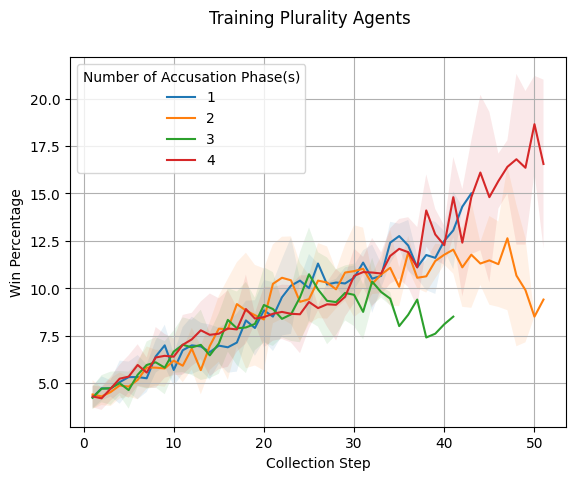

In [13]:
fig, ax = plt.subplots()

tolerant_p_results = [tolerant_mean(a_votes) for a_votes in [one_accusation_p_votes, two_accusation_p_votes, three_accusation_p_votes, four_accusation_p_votes]]

for i, tolerant_result in enumerate(tolerant_p_results):
    y, std = tolerant_result
    ax.plot(np.arange(len(y))+1, y, label=i+1)
    ax.fill_between(np.arange(len(y))+1, y-std, y+std, alpha=0.1)

plt.ylabel("Win Percentage")
plt.xlabel("Collection Step")
plt.legend(title="Number of Accusation Phase(s)")
plt.suptitle("Training Plurality Agents")
plt.grid(True)

print("\n")

In [8]:
import tikzplotlib

We can see that regardless of one or many accusation phases, there is no definitive trend as to which performs the best. We had an outlier with a win-rate above $40\%$ with $2$ accusation phases, however just based on the graph, $4$ accusation phases scored higher on average. Given what we know in our [plurality analysis](p-analysis), it might be that more accusation phases are needed for agents that can only cast a vote for a single candidate. More time is needed to learn complex strategies for signaling intent.

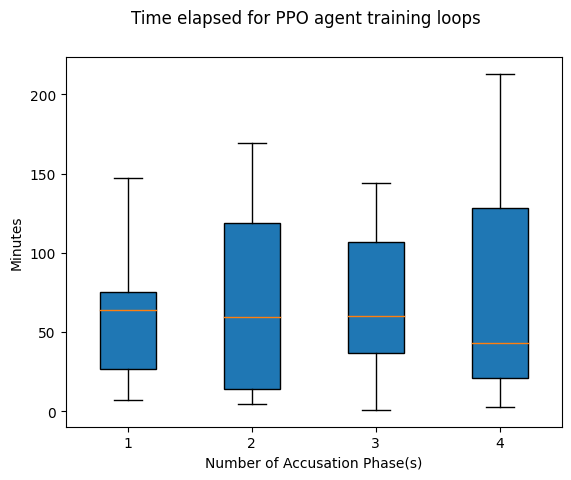

In [117]:
four_accusation_p_times = [(accusation.info.end_time - accusation.info.start_time)/(1000 * 60) for accusation in four_accusations_p]
three_accusation_p_times = [(accusation.info.end_time - accusation.info.start_time)/(1000 * 60) for accusation in three_accusations_p]
two_accusation_p_times = [(accusation.info.end_time - accusation.info.start_time)/(1000 * 60) for accusation in two_accusations_p]
one_accusation_p_times = [(accusation.info.end_time - accusation.info.start_time)/(1000 * 60) for accusation in one_accusations_p]

plt.boxplot([one_accusation_p_times, two_accusation_p_times, three_accusation_p_times, four_accusation_p_times],
            vert=True,  # vertical box alignment
            patch_artist=True,  # fill with color
            labels=[1,2,3,4])
plt.ylabel("Minutes")
plt.xlabel("Number of Accusation Phase(s)")
plt.suptitle("Time elapsed for PPO agent training loops")
    
print("\n")

Stability of training was quite poor for plurality voting, regardless of number of accusation phases. 

### Approval Training

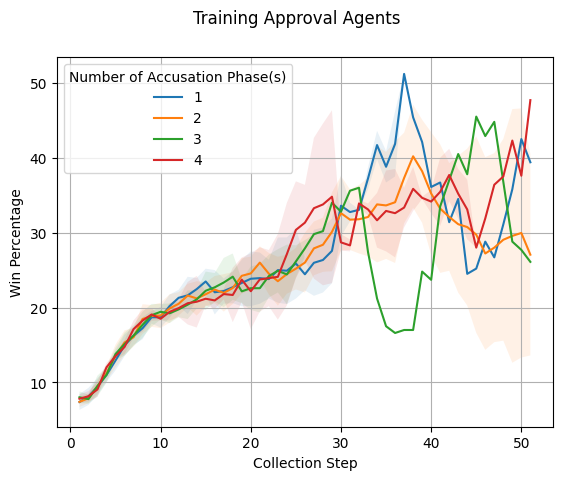

In [14]:
fig, ax = plt.subplots()

tolerant_a_results = [tolerant_mean(a_votes) for a_votes in [one_accusation_a_votes, two_accusation_a_votes, three_accusation_a_votes, four_accusation_a_votes]]

for i, tolerant_result in enumerate(tolerant_a_results):
    y, std = tolerant_result
    ax.plot(np.arange(len(y))+1, y, label=i+1)
    ax.fill_between(np.arange(len(y))+1, y-std, y+std, alpha=0.1)

plt.ylabel("Win Percentage")
plt.xlabel("Collection Step")
plt.legend(title="Number of Accusation Phase(s)")
plt.suptitle("Training Approval Agents")
plt.grid(True)
print("\n")

We can see that regardless of number of accusation phases, it seems as though for the first half, agents learn roughly at the same rate, probably learning the same behavior. Afterwards, learning becomes more temperamental. A lot of runs did not make it this far either, so some data we have is only from a single run. Each accusation phase was able to reach about $.50$ win-rates, and given the lack of data, we cannot definitively say one was better than the other. The analysis was done with 2 accusation phases as some of our saved agents initially came from this batch.

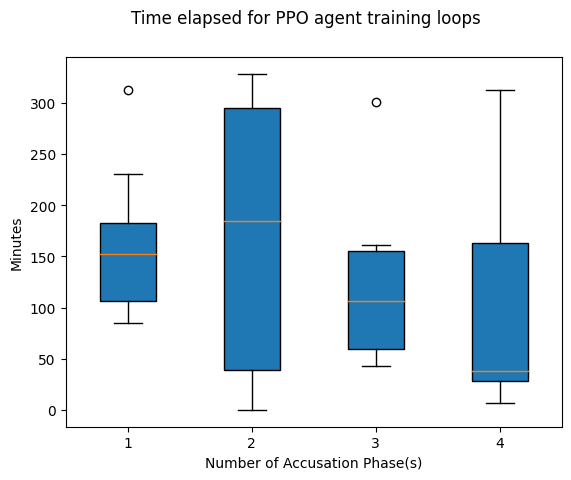

In [114]:
four_accusation_a_times = [(accusation.info.end_time - accusation.info.start_time)/(1000 * 60) for accusation in four_accusations_a]
three_accusation_a_times = [(accusation.info.end_time - accusation.info.start_time)/(1000 * 60) for accusation in three_accusations_a]
two_accusation_a_times = [(accusation.info.end_time - accusation.info.start_time)/(1000 * 60) for accusation in two_accusations_a]
one_accusation_a_times = [(accusation.info.end_time - accusation.info.start_time)/(1000 * 60) for accusation in one_accusations_a]

plt.boxplot([one_accusation_a_times, two_accusation_a_times, three_accusation_a_times, four_accusation_a_times],
            vert=True,  # vertical box alignment
            patch_artist=True,  # fill with color
            labels=[1,2,3,4])
plt.ylabel("Minutes")
plt.xlabel("Number of Accusation Phase(s)")
plt.suptitle("Time elapsed for PPO agent training loops")
    
print("\n")

We can also see that the more accusation phases we added, the less stable the training became. This was another reason we stuck with $2$ accusation phases. For the hyperparameters we had settled on, it seemed the most stable.

### Comparing Approval and Plurality

We can see that when comparing approval and purality training, an approval voting mechanism provided much better win-rates, and a faster and more consistent learning experience. The increased expressibility provided by approval voting gave learning agents a more consistent experience and way to signal.

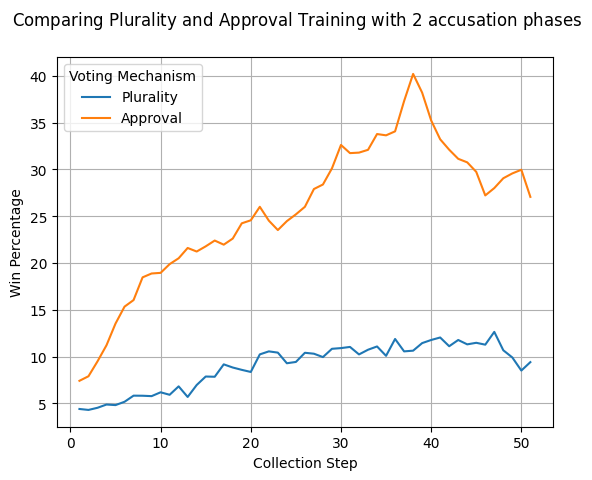

In [16]:
fig, ax = plt.subplots()

tolerant_results = [tolerant_mean(a_votes) for a_votes in [one_accusation_a_votes, two_accusation_a_votes, three_accusation_a_votes, four_accusation_a_votes]]


y_p, std_p = tolerant_p_results[1]
y_a, std_a = tolerant_a_results[1]

ax.plot(np.arange(len(y_p))+1, y_p, label="Plurality")
# ax.fill_between(np.arange(len(y_p))+1, y_p-std_p, y_p+std_p, alpha=0.1)

ax.plot(np.arange(len(y_a))+1, y_a, label="Approval")
# ax.fill_between(np.arange(len(y_a))+1, y_a-std_a, y_a+std_a, alpha=0.1)

plt.ylabel("Win Percentage")
plt.xlabel("Collection Step")
plt.legend(title="Voting Mechanism")
plt.suptitle("Comparing Plurality and Approval Training with $2$ accusation phases")
plt.grid(True)
print("\n")

[^mlflow-tooling]:https://mlflow.org/